In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

image_dimensions = {'height': 256, 'width': 256, 'channels': 3}

class Classifier:
    def __init__(self):
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss='mean_squared_error',
                           metrics=['accuracy'])

    def init_model(self):
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

# Clone the repository
!git clone https://github.com/LoreJob/DeepFake-Dct.git

meso = Meso4()

dataGenerator = ImageDataGenerator(rescale=1./255)

train_generator = dataGenerator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = dataGenerator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Validation',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train the model
history = meso.model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

meso.model.save('meso4_model.h5')

fatal: destination path 'DeepFake-Dct' already exists and is not an empty directory.


Found 140002 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Epoch 1/10
1547/4376 [=========>....................] - ETA: 3:16 - loss: 0.1958 - accuracy: 0.7096

In [6]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_loss, test_accuracy = meso.model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = meso.model.predict(test_generator)

Found 10905 images belonging to 2 classes.
341/341 [==============================] - 20s 58ms/step - loss: 0.0934 - accuracy: 0.8768
Test Loss: 0.09335699677467346
Test Accuracy: 0.8768454790115356
341/341 [==============================] - 21s 60ms/step


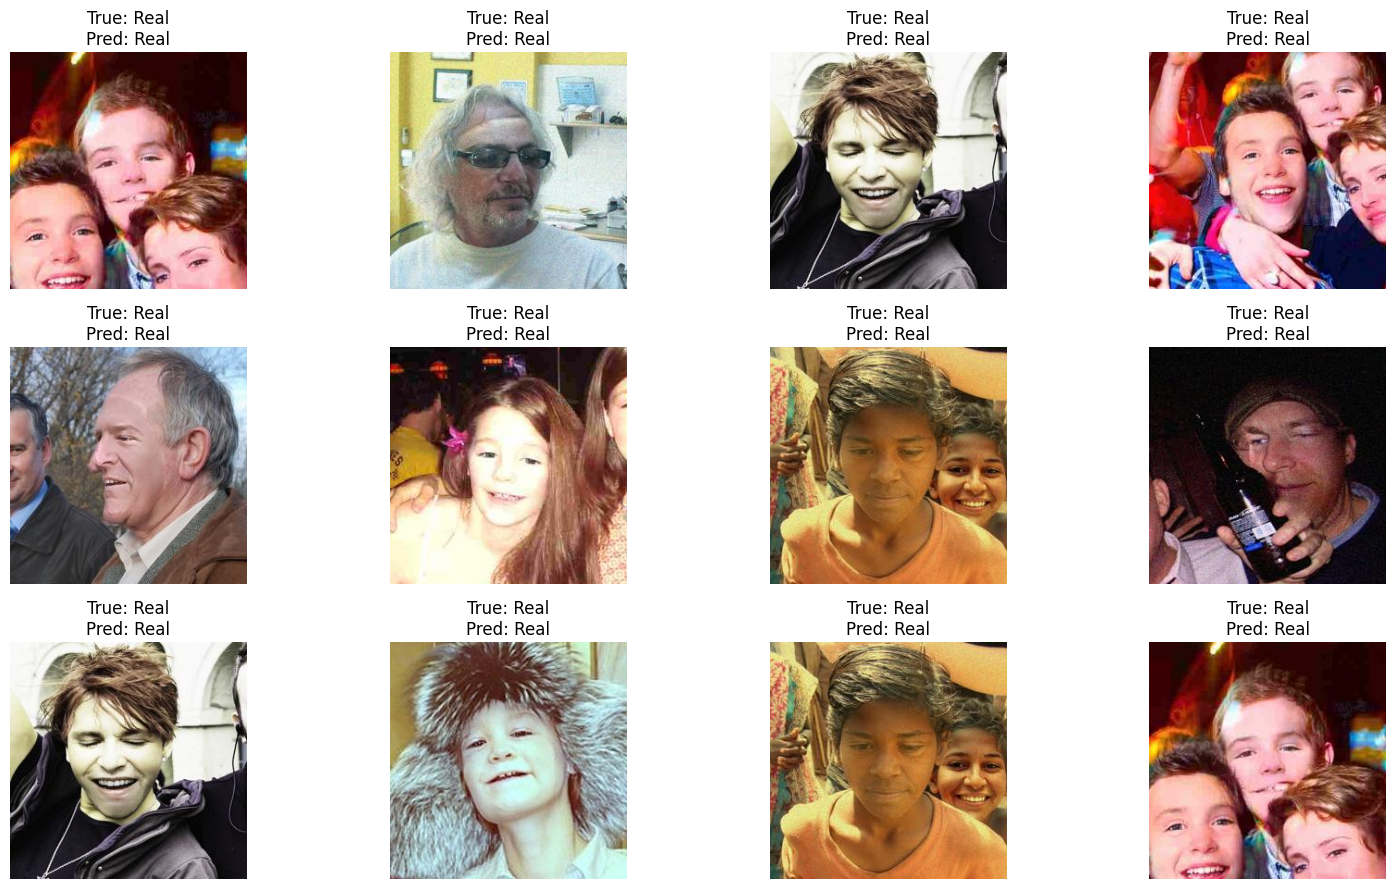

In [12]:
def plot_predictions(images, labels, predictions, class_indices):
    fig = plt.figure(figsize=(16, 9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i, idx in enumerate(subset):
        ax = fig.add_subplot(3, 4, i + 1)
        ax.imshow(images[idx])
        pred_label = 'Fake' if predictions[idx] > 0.5 else 'Real'
        true_label = 'Fake' if labels[idx] > 0.5 else 'Real'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

test_images, test_labels = next(test_generator)
plot_predictions(test_images, test_labels, test_predictions[:64], test_generator.class_indices)